# Bulk short read RNA-seq exploratory analysis with python

We have data from 2 patient-derived muscle cell lines, Control and FSHD2, that were differentiated in culture over 5 days as described in [this paper](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1008754). Bulk short-read RNA-seq was performed using polyA primers and Illumina sequencing. There are 48 total samples from the 2 conditions across 6 timepoints (0-5 days), 2 biological replicates, and 2 technical replicates each, but I just had you map 8 samples: Control and FSHD2 at 3 and 5 days, 1 biological replicate and 2 technical replicates each. 

To quantify gene expression, reads were mapped to the human genome using [kallisto](https://pachterlab.github.io/kallisto/about), and the resulting counts were saved as a tsv file for each sample.

This notebook assumes you have run `kallisto_quant.sh` (and therefore have a `kallisto_output` folder one directory above this one). 

# Import data into python

Concatenate all samples together into 1 gene expression matrix of RNA quantifications normalized by TPM (transcripts per million). TPM accounts for the total number of reads that the sample got when it was sequenced, and the length of the transcript. Transcript lengths (# bases) vary a lot! Compare the Titin transcript at > 100,000 base pairs vs. the average length of a human transcript ~2,000 base pairs.

In [1]:
# Load some libraries 
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.decomposition import PCA

sns.set_context("paper", font_scale=2)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Read in metadata file; only really care about certain columns for plotting purposes
metadata = pd.read_csv("/data/class/cosmos2023/PUBLIC/ta-github/data/fshd_metadata.csv", 
                       usecols=['Run', 'Sample', 'Individual', 'fshd_status', 'day_of_differentiation'])

In [3]:
# Directory containing the output folders 
output_dir = '../kallisto_output'

# If you had trouble running kallisto_quant.sh, use the output in the results folder from ta-github:
#output_dir = 'results/kallisto_output'

# List to store individual dataframes
dfs = []

In [4]:
# Loop through each folder in the output directory
for folder in os.listdir(output_dir):
    folder_path = os.path.join(output_dir, folder)
    file_path = os.path.join(folder_path, 'gene_abundance.tsv')

    # Read gene_abundance.tsv as a dataframe
    df = pd.read_csv(file_path, sep ='\t')
    tpm_col = df['tpm']  # Extract tpm column
    dfs.append(tpm_col) # Add gene expression measurements from each sample to a growing list

In [5]:
# Create a dataframe from the list of measurements from all the samples
merged_df = pd.concat(dfs, axis=1)
merged_df.columns = os.listdir(output_dir)  # Assign sample names as column names


In [6]:
# Create a dictionary mapping Run to Sample from the metadata
column_mapping = dict(zip(metadata['Run'], metadata['Sample']))

# Rename the columns using the mapping
merged_df.rename(columns=column_mapping, inplace=True)

# Reorder columns (not necessary, just makes it nicer to look at)
column_order = ['Control-1 Day 3 Rep 1', 'Control-1 Day 3 Rep 2', 
                'Control-1 Day 5 Rep 1', 'Control-1 Day 5 Rep 2', 
                'FSHD2-1 Day 3 Rep 1', 'FSHD2-1 Day 3 Rep 2', 
                'FSHD2-1 Day 5 Rep 1', 'FSHD2-1 Day 5 Rep 2']
merged_df = merged_df.reindex(columns=column_order)

# Set index (like row names) to be the gene name
merged_df = merged_df.set_index(df['gene_name'])


In [7]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 58884 entries, DDX11L1 to AC213203.1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Control-1 Day 3 Rep 1  58884 non-null  float64
 1   Control-1 Day 3 Rep 2  58884 non-null  float64
 2   Control-1 Day 5 Rep 1  58884 non-null  float64
 3   Control-1 Day 5 Rep 2  58884 non-null  float64
 4   FSHD2-1 Day 3 Rep 1    58884 non-null  float64
 5   FSHD2-1 Day 3 Rep 2    58884 non-null  float64
 6   FSHD2-1 Day 5 Rep 1    58884 non-null  float64
 7   FSHD2-1 Day 5 Rep 2    58884 non-null  float64
dtypes: float64(8)
memory usage: 4.0+ MB
None


In [8]:
print(merged_df.shape)

(58884, 8)


In [9]:
print(merged_df.head())

             Control-1 Day 3 Rep 1  Control-1 Day 3 Rep 2  \
gene_name                                                   
DDX11L1                   0.199543                 0.0000   
WASH7P                    1.628010                 1.2081   
MIR6859-1                 0.000000                 0.0000   
MIR1302-2HG               0.000000                 0.0000   
MIR1302-2                 0.000000                 0.0000   

             Control-1 Day 5 Rep 1  Control-1 Day 5 Rep 2  \
gene_name                                                   
DDX11L1                   0.275608               0.079013   
WASH7P                    1.912200               1.367780   
MIR6859-1                 0.000000               0.000000   
MIR1302-2HG               0.000000               0.000000   
MIR1302-2                 0.000000               0.000000   

             FSHD2-1 Day 3 Rep 1  FSHD2-1 Day 3 Rep 2  FSHD2-1 Day 5 Rep 1  \
gene_name                                                         

In [10]:
# drop unexpressed genes
merged_df = merged_df.loc[merged_df.sum(axis=1) != 0]

print(merged_df.info())
print(merged_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 25075 entries, DDX11L1 to AC213203.2
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Control-1 Day 3 Rep 1  25075 non-null  float64
 1   Control-1 Day 3 Rep 2  25075 non-null  float64
 2   Control-1 Day 5 Rep 1  25075 non-null  float64
 3   Control-1 Day 5 Rep 2  25075 non-null  float64
 4   FSHD2-1 Day 3 Rep 1    25075 non-null  float64
 5   FSHD2-1 Day 3 Rep 2    25075 non-null  float64
 6   FSHD2-1 Day 5 Rep 1    25075 non-null  float64
 7   FSHD2-1 Day 5 Rep 2    25075 non-null  float64
dtypes: float64(8)
memory usage: 1.7+ MB
None
(25075, 8)


In [11]:
# Write the merged dataframe to a new file
merged_df.to_csv('data/tpm_matrix.tsv', sep='\t', index=False)


# PCA (principal component analysis) 
[5-minute explanation of PCA on Youtube](https://www.youtube.com/watch?v=HMOI_lkzW08&t=28s)

In [12]:
input_df = merged_df.transpose() # transpose the matrix
data = input_df.values # just get the numbers
pca = PCA(merged_df.shape[1]) # compute the same # of PCs as samples
pca.fit(data)

PCA(n_components=8)

   prop_variance  pct_variance  PC
0   6.148922e-01  6.148922e+01   1
1   2.019525e-01  2.019525e+01   2
2   9.152513e-02  9.152513e+00   3
3   4.755336e-02  4.755336e+00   4
4   3.129849e-02  3.129849e+00   5
5   6.967970e-03  6.967970e-01   6
6   5.810383e-03  5.810383e-01   7
7   7.304124e-31  7.304124e-29   8


/opt/apps/python/3.8.0/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


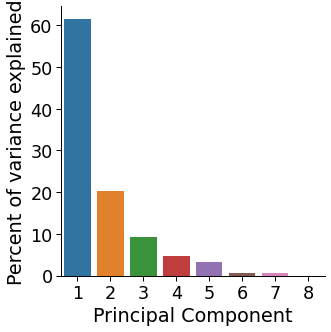

In [13]:
# Make df to plot the percent variance explained
pca_df = pd.DataFrame(data=pca.explained_variance_ratio_,
                      columns=['prop_variance'])

# compute percent variance from proportion variance
pca_df['pct_variance'] = pca_df.prop_variance*100
pca_df['PC'] = list(range(1, merged_df.shape[1]+1))
print(pca_df)

# Use Seaborn library to make categorical bar plot
ax = sns.catplot(data=pca_df, x='PC', y='pct_variance', kind='bar')

# Add nice x and y axis labels
ax.set(ylabel='Percent of variance explained', xlabel='Principal Component')

In [14]:
# first calculate the PCA representation of the data
pca_data = pca.transform(data) 
cols = ['PC{} ({:.1f}%)'.format(pc, var) for pc, var in zip(pca_df.PC, pca_df.pct_variance)]
print(cols)
pca_df = pd.DataFrame(data=pca_data, columns=cols)
pca_df.set_index(input_df.index, inplace=True)

# Perform a merge based on matching indices
pca_df = pca_df.merge(metadata, left_index=True, right_on='Sample')

['PC1 (61.5%)', 'PC2 (20.2%)', 'PC3 (9.2%)', 'PC4 (4.8%)', 'PC5 (3.1%)', 'PC6 (0.7%)', 'PC7 (0.6%)', 'PC8 (0.0%)']


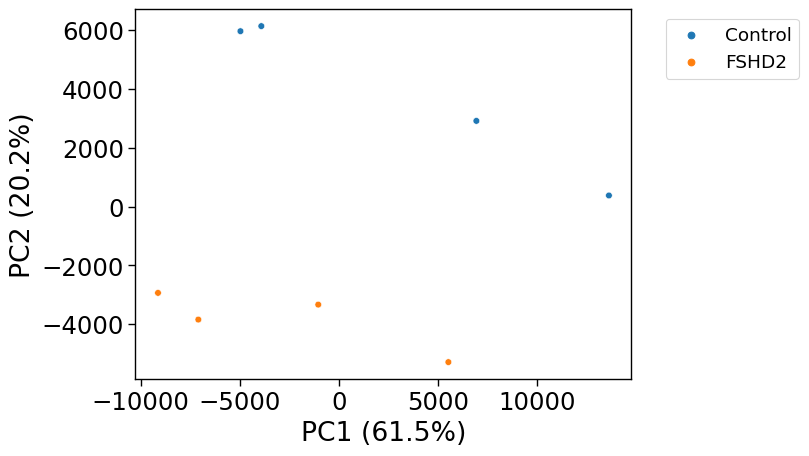

In [15]:
ax = sns.scatterplot(data=pca_df, x=cols[0], y=cols[1], hue='fshd_status')

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')

## make it pretty!

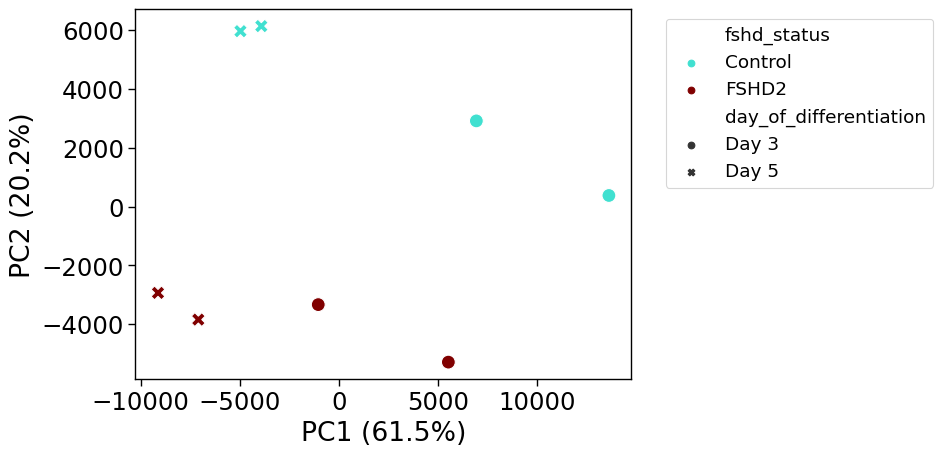

In [16]:
# Make a mini dictionary to assign color to fshd status
c_dict = {'FSHD2': 'maroon', 
          'Control': 'turquoise' }

ax = sns.scatterplot(data=pca_df, x=cols[0], y=cols[1], 
                     s=100, # size of point
                     hue='fshd_status', palette=c_dict, style='day_of_differentiation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')


In [36]:
# Get the top weighted genes for PC1 and PC2
top_genes_pc1 = input_df.columns[pca.components_[0].argsort()[::-1]]
top_genes_pc2 = input_df.columns[pca.components_[1].argsort()[::-1]]

# Print the top weighted genes for PC1
print("Top genes for PC1:")
print(top_genes_pc1.to_frame().head(n=15))

# Print the top weighted genes for PC2
print("Top genes for PC2:")
print(top_genes_pc2.to_frame().head(n=15))


Top genes for PC1:
          gene_name
gene_name          
TGFBI         TGFBI
FTH1           FTH1
LGALS1       LGALS1
ACTA1         ACTA1
ACTB           ACTB
TMSB10       TMSB10
TUBA1A       TUBA1A
PKM             PKM
TIMP1         TIMP1
MT-CO2       MT-CO2
SPARC         SPARC
MT2A           MT2A
MYL6           MYL6
TUBA1B       TUBA1B
COL1A1       COL1A1
Top genes for PC2:
             gene_name
gene_name             
ACTC1            ACTC1
TUBA1A          TUBA1A
AC010970.1  AC010970.1
TPM2              TPM2
S100A6          S100A6
S100A4          S100A4
TNNT2            TNNT2
LGALS1          LGALS1
THBS1            THBS1
MTRNR2L12    MTRNR2L12
DCN                DCN
FTH1              FTH1
DES                DES
CALM1            CALM1
HSPB1            HSPB1


# Heatmap

In [17]:
# order matrix based on expression so we can get some highly-expressed guys
# (but usually for these you'll want to curate the set of genes in a more intelligent way)
merged_df['total'] = merged_df.sum(axis=1)
merged_df.sort_values(by='total', ascending=False, inplace=True)
merged_df.drop('total', axis=1, inplace=True)

# log2 transform and add pseudocount -- common way to transform RNA-seq data for visualization
merged_df = np.log2(merged_df + 1) 

# show top 15 genes
merged_df_top15 = merged_df[:15] 

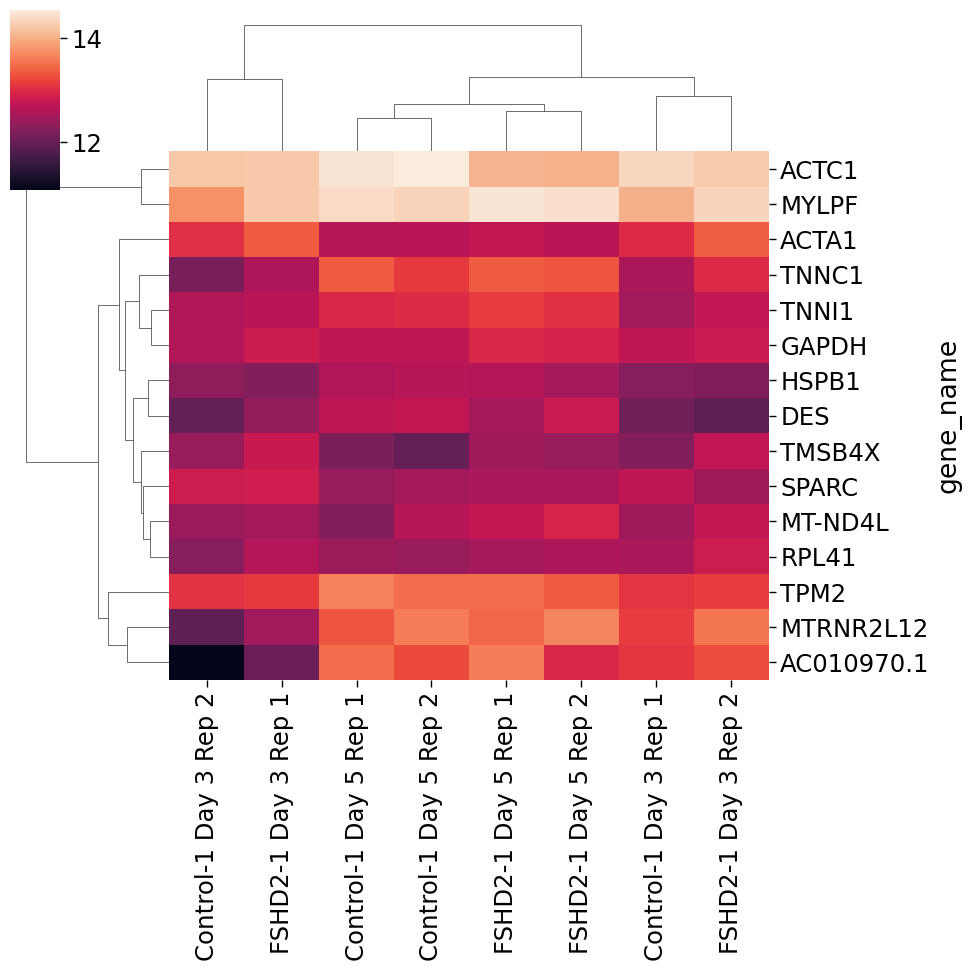

In [18]:
# Use clustermap function in seaborn to make heatmap
ax = sns.clustermap(data=merged_df_top15)

# Try to recreate part of figure 1c from the paper

In [19]:
genes = pd.read_csv("/data/class/cosmos2023/PUBLIC/ta-github/data/Fig1C_genes.csv")


In [20]:
# subset df for the genes that were in the figure
merged_df_paper = merged_df[merged_df.index.isin(genes['gene_name'])]

## make it pretty!
Other color palettes listed [here](https://seaborn.pydata.org/tutorial/color_palettes.html)

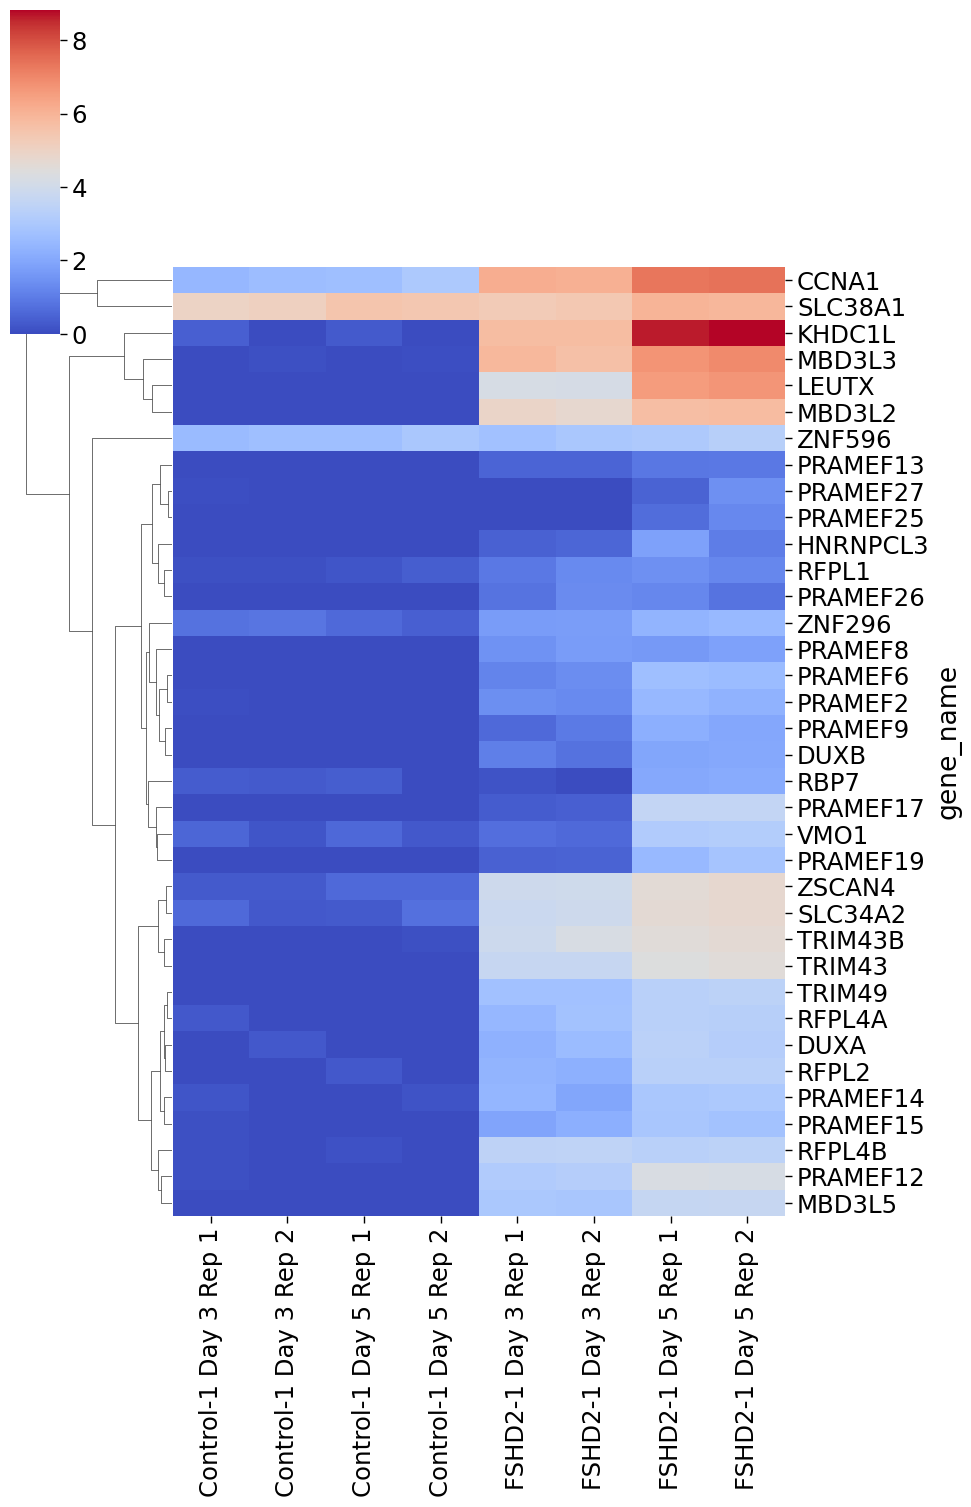

In [21]:
# Set the desired width and height in inches
width = 10
height = 18

# Turn off column clustering, change color map, and adjust the yticklabels to label every row
ax = sns.clustermap(data=merged_df_paper, col_cluster=False, cmap="coolwarm", yticklabels=True)

# Set the figsize parameter of the clustermap plot
ax.figure.set_size_inches(width, height)

## Check expression of any gene you're interested in 

In [22]:
# subset df for the genes that were in the figure

mygenes = ['PAX7', 'MYOD1', 'MYF5', 'MYOG', 'MYH1', 'MYH2', 'MYH4', 'MYH7']

merged_df_my_genes = merged_df[merged_df.index.isin(mygenes)]

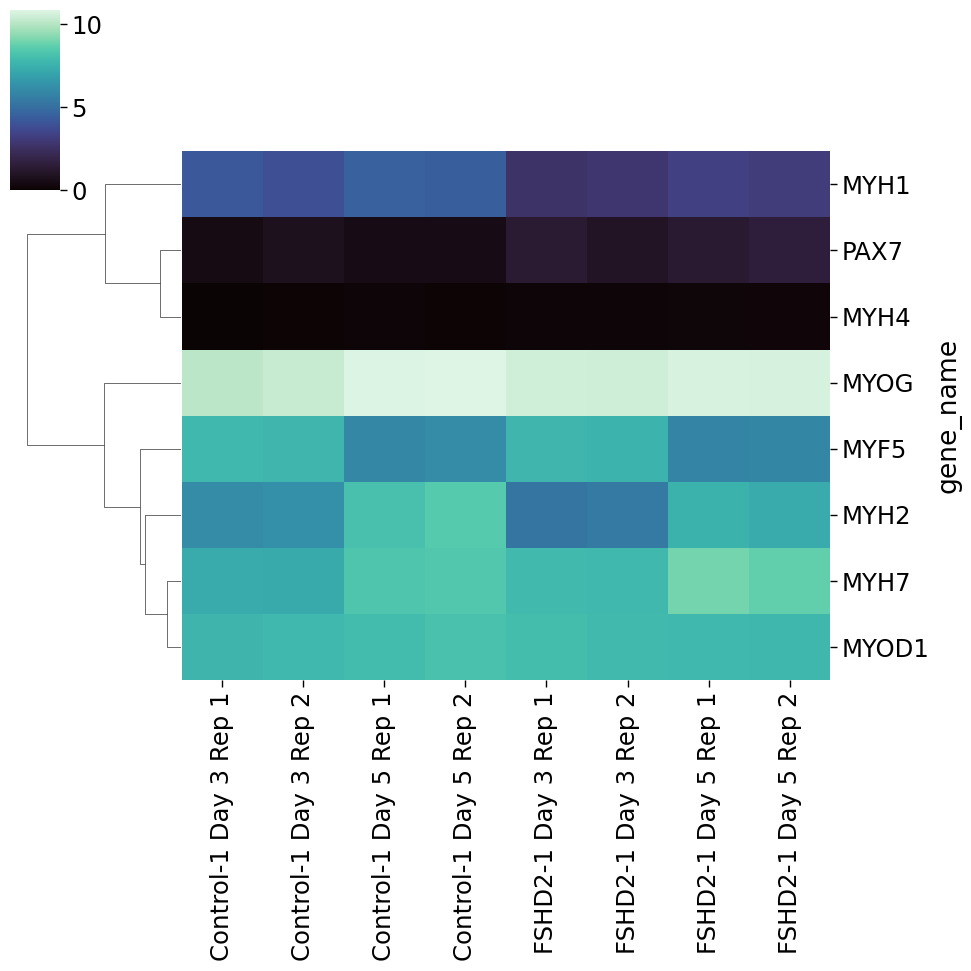

In [23]:
# Turn off column clustering, change color map, and adjust the yticklabels to label every row
ax = sns.clustermap(data=merged_df_my_genes, col_cluster=False, cmap="mako")
plt.setp(ax.ax_heatmap.get_yticklabels(), rotation=0)  # y axis labels were getting rotated for some reason
plt.show()
